In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import make_prior_knowledge
print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])
np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)
from datetime import datetime


['1.25.2', '2.1.0', '0.20.1', '1.8.1']


In [2]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x[1]' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d


In [3]:
projects = pd.read_csv('train.csv')
print(projects.columns)
print(projects.head())


Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')
          ID  Estimated_Insects_Count  Crop_Type  Soil_Type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   Pesticide_Use_Category  Number_Doses_Week  Number_Weeks_Used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

 

In [4]:
projects.Crop_Damage.value_counts()

Crop_Damage
0    74238
1    12307
2     2313
Name: count, dtype: int64

In [5]:
projects.loc[projects['Crop_Damage']==2,'Crop_Damage']=1

In [6]:
projects=projects.drop(columns='ID',axis=1)

In [7]:
print(projects.isnull().sum())

Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64


In [8]:
projects=projects.dropna()

In [9]:
#projects=projects.drop(columns='Number_Weeks_Used',axis=1)

In [10]:
projects.columns

Index(['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')

In [11]:
projects.Estimated_Insects_Count=np.log(projects.Estimated_Insects_Count)

In [12]:
pk = make_prior_knowledge(n_variables=len(projects.columns), sink_variables=[8])

In [13]:
model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(projects)
labels = [f'{i}. {col}' for i, col in enumerate(projects.columns)]
print(labels)


['0. Estimated_Insects_Count', '1. Crop_Type', '2. Soil_Type', '3. Pesticide_Use_Category', '4. Number_Doses_Week', '5. Number_Weeks_Used', '6. Number_Weeks_Quit', '7. Season', '8. Crop_Damage']


In [14]:
dot = make_graph(model.adjacency_matrix_, labels)
print(dot)

digraph {
	"1. Crop_Type" -> "0. Estimated_Insects_Count" [label=0.10]
	"2. Soil_Type" -> "0. Estimated_Insects_Count" [label=0.03]
	"3. Pesticide_Use_Category" -> "0. Estimated_Insects_Count" [label=-0.05]
	"5. Number_Weeks_Used" -> "0. Estimated_Insects_Count" [label=0.04]
	"6. Number_Weeks_Quit" -> "0. Estimated_Insects_Count" [label=0.05]
	"1. Crop_Type" -> "2. Soil_Type" [label=-0.32]
	"1. Crop_Type" -> "3. Pesticide_Use_Category" [label=0.28]
	"2. Soil_Type" -> "3. Pesticide_Use_Category" [label=0.10]
	"1. Crop_Type" -> "4. Number_Doses_Week" [label=-6.36]
	"2. Soil_Type" -> "4. Number_Doses_Week" [label=0.85]
	"1. Crop_Type" -> "5. Number_Weeks_Used" [label=-5.53]
	"2. Soil_Type" -> "5. Number_Weeks_Used" [label=-3.36]
	"3. Pesticide_Use_Category" -> "5. Number_Weeks_Used" [label=4.79]
	"4. Number_Doses_Week" -> "5. Number_Weeks_Used" [label=0.07]
	"6. Number_Weeks_Quit" -> "5. Number_Weeks_Used" [label=-0.49]
	"1. Crop_Type" -> "6. Number_Weeks_Quit" [label=-2.66]
	"3. Pesticid

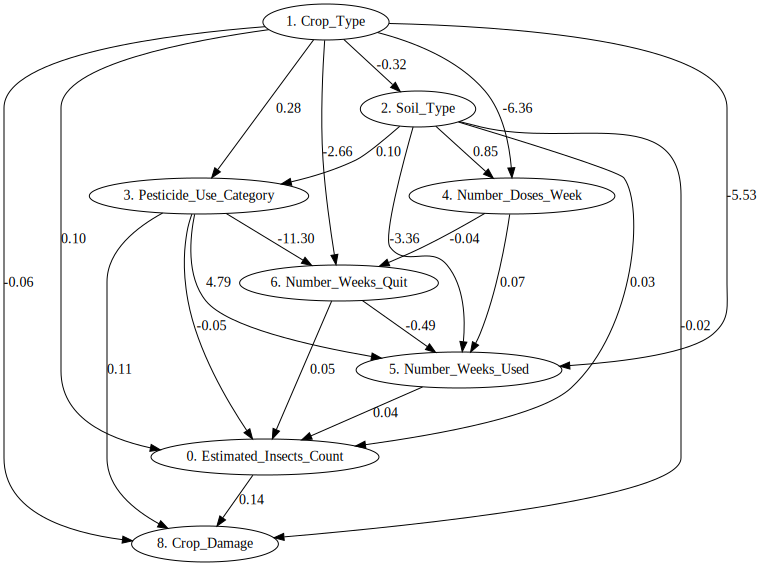

In [15]:
dot

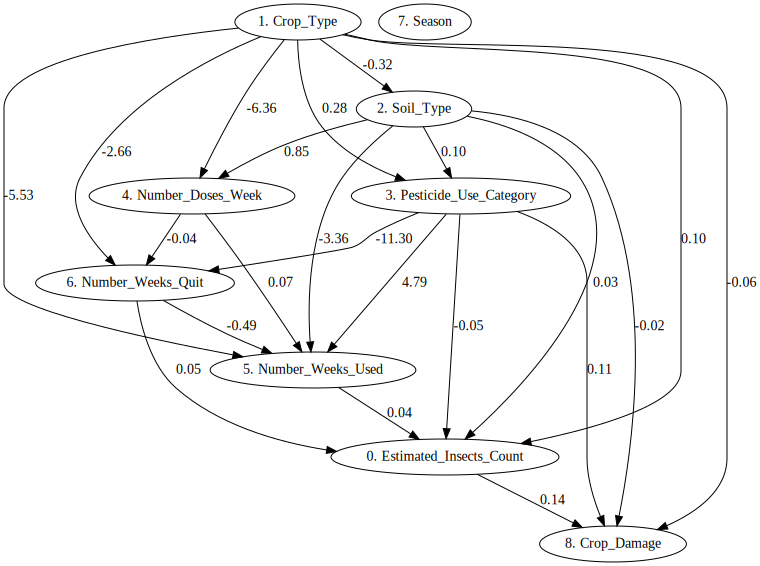

In [16]:
make_dot(model.adjacency_matrix_, labels)

In [17]:
from sklearn.linear_model import LogisticRegression
target = 8
features = [i for i in range(projects.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(projects.iloc[:, features].values, projects.iloc[:, target].values)

LogisticRegression(solver='liblinear')

In [18]:
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(projects.values, target, reg)
df_effects = pd.DataFrame()
df_effects['feature'] = projects.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,Estimated_Insects_Count,0.228856,0.133245
1,Crop_Type,0.021478,0.023029
2,Soil_Type,0.020836,0.022292
3,Pesticide_Use_Category,0.131424,0.093072
4,Number_Doses_Week,0.026030,0.028343
5,Number_Weeks_Used,0.168491,0.110248
6,Number_Weeks_Quit,0.024648,0.026712
7,Season,0.002423,0.002441
8,Crop_Damage,0.000000,0.000000


In [19]:
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(projects.columns[max_index[0]])


Estimated_Insects_Count


In [20]:
import statsmodels.formula.api as smf
result_try=smf.logit(formula=
                     "Crop_Damage ~ Estimated_Insects_Count + C(Crop_Type)+ C(Soil_Type)+ C(Pesticide_Use_Category)+Number_Doses_Week + Number_Weeks_Quit + C(Season) + Number_Weeks_Used",
                     data=projects).fit()
print(result_try.summary())

Optimization terminated successfully.
         Current function value: 0.370382
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Crop_Damage   No. Observations:                79858
Model:                          Logit   Df Residuals:                    79847
Method:                           MLE   Df Model:                           10
Date:                Thu, 05 Oct 2023   Pseudo R-squ.:                  0.1707
Time:                        11:41:33   Log-Likelihood:                -29578.
converged:                       True   LL-Null:                       -35666.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.0987      0.213     -9.865     

In [21]:

#result_try_all=smf.logit(formula=
#                     "Crop_Damage ~ Estimated_Insects_Count + C(Crop_Type)+ C(Soil_Type)+ C(Pesticide_Use_Category)+ Number_Weeks_Quit + C(Season) + Number_Weeks_Used",
#                     data=projects).fit()
#print(result_try_all.summary())

Optimization terminated successfully.
         Current function value: 0.370383
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Crop_Damage   No. Observations:                79858
Model:                          Logit   Df Residuals:                    79848
Method:                           MLE   Df Model:                            9
Date:                Thu, 05 Oct 2023   Pseudo R-squ.:                  0.1707
Time:                        11:41:34   Log-Likelihood:                -29578.
converged:                       True   LL-Null:                       -35666.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.0860      0.210     -9.930     

In [22]:
projects2=projects.drop(columns='Crop_Damage',axis=1)

In [23]:
projects2.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,5.236442,1,0,1,0,0.0,0,1
1,5.342334,1,0,1,0,0.0,0,2
2,5.549076,1,0,1,0,0.0,0,2
3,5.549076,1,1,1,0,0.0,0,2
4,5.834811,1,0,1,0,0.0,0,2


In [24]:
pk2 = make_prior_knowledge(n_variables=len(projects2.columns), sink_variables=[0])
model2 = lingam.DirectLiNGAM(prior_knowledge=pk2)
model2.fit(projects2)
labels = [f'{i}. {col}' for i, col in enumerate(projects2.columns)]
print(labels)


['0. Estimated_Insects_Count', '1. Crop_Type', '2. Soil_Type', '3. Pesticide_Use_Category', '4. Number_Doses_Week', '5. Number_Weeks_Used', '6. Number_Weeks_Quit', '7. Season']


In [25]:
dot2 = make_graph(model2.adjacency_matrix_, labels)
print(dot2)

digraph {
	"1. Crop_Type" -> "0. Estimated_Insects_Count" [label=0.10]
	"2. Soil_Type" -> "0. Estimated_Insects_Count" [label=0.03]
	"3. Pesticide_Use_Category" -> "0. Estimated_Insects_Count" [label=-0.05]
	"5. Number_Weeks_Used" -> "0. Estimated_Insects_Count" [label=0.04]
	"6. Number_Weeks_Quit" -> "0. Estimated_Insects_Count" [label=0.05]
	"1. Crop_Type" -> "2. Soil_Type" [label=-0.35]
	"3. Pesticide_Use_Category" -> "2. Soil_Type" [label=0.11]
	"1. Crop_Type" -> "3. Pesticide_Use_Category" [label=0.24]
	"1. Crop_Type" -> "4. Number_Doses_Week" [label=-6.74]
	"2. Soil_Type" -> "4. Number_Doses_Week" [label=0.71]
	"3. Pesticide_Use_Category" -> "4. Number_Doses_Week" [label=1.38]
	"1. Crop_Type" -> "5. Number_Weeks_Used" [label=-5.53]
	"2. Soil_Type" -> "5. Number_Weeks_Used" [label=-3.36]
	"3. Pesticide_Use_Category" -> "5. Number_Weeks_Used" [label=4.79]
	"4. Number_Doses_Week" -> "5. Number_Weeks_Used" [label=0.07]
	"6. Number_Weeks_Quit" -> "5. Number_Weeks_Used" [label=-0.49]
	

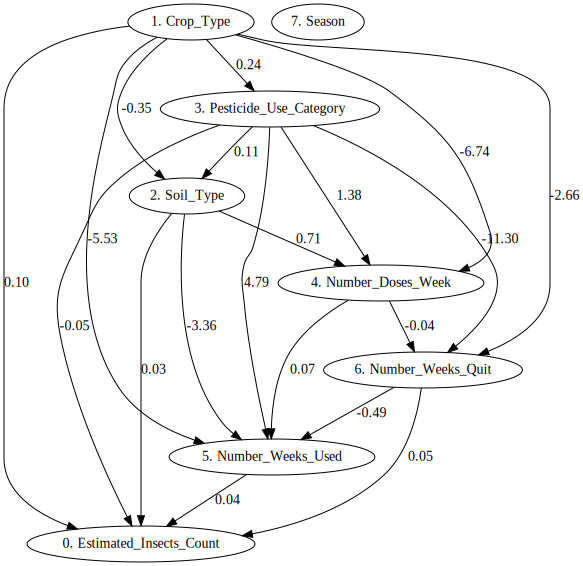

In [26]:
make_dot(model2.adjacency_matrix_, labels)

In [27]:
from sklearn.linear_model import LinearRegression
target = 0
features2 = [i for i in range(projects2.shape[1]) if i != target]
reg2 = LinearRegression()
reg2.fit(projects2.iloc[:, features2].values, projects2.iloc[:, target].values)



LinearRegression()

In [30]:
ce2 = lingam.CausalEffect(model2)
effects2 = ce2.estimate_effects_on_prediction(projects2, target, reg2)


In [31]:
df_effects2 = pd.DataFrame()
df_effects2['feature'] = projects2.columns
df_effects2['effect_plus'] = effects2[:, 0]
df_effects2['effect_minus'] = effects2[:, 1]
df_effects2

,feature,effect_plus,effect_minus
0,Estimated_Insects_Count,0.000000,0.000000
1,Crop_Type,0.074295,0.074295
2,Soil_Type,0.056215,0.056215
3,Pesticide_Use_Category,0.064980,0.064980
4,Number_Doses_Week,0.064107,0.064107
5,Number_Weeks_Used,0.528206,0.528206
6,Number_Weeks_Quit,0.239870,0.239870
7,Season,0.001639,0.001639


In [60]:
max_index = np.unravel_index(np.argmax(effects2), effects2.shape)
print(projects2.columns[max_index[0]])


Number_Weeks_Used


In [61]:
import statsmodels.formula.api as smf
result_try2=smf.ols(formula=
                     "Estimated_Insects_Count~C(Crop_Type)+ C(Soil_Type)+ C(Pesticide_Use_Category)+Number_Doses_Week + Number_Weeks_Quit + C(Season)",
                     data=projects2).fit()
print(result_try2.summary())

                               OLS Regression Results                              
Dep. Variable:     Estimated_Insects_Count   R-squared:                       0.125
Model:                                 OLS   Adj. R-squared:                  0.125
Method:                      Least Squares   F-statistic:                     1429.
Date:                     Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                             09:48:33   Log-Likelihood:                -77054.
No. Observations:                    79858   AIC:                         1.541e+05
Df Residuals:                        79849   BIC:                         1.542e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------